In [1]:
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [2]:
m = 1000
n = 100000
r = 10

X0 = np.random.randn(m, m)
X, _ = np.linalg.qr(X0)

Y0 = np.random.randn(n, m)
Y, _ = np.linalg.qr(Y0)

d = [10-i+1 if i <= 10 else 0.004 for i in range(1000)]
D = np.diag(d)

A = X.dot(D).dot(Y.T)

In [3]:
def random_svd(A, c, r = 10):
    
    m,n = A.shape
    norm_A = np.linalg.norm(A)
    norm_Ai = np.array([np.linalg.norm(A[:, i]) for i in range(n)])
    prob_n = norm_Ai ** 2 / norm_A ** 2
    norm_Aj = np.array([np.linalg.norm(A[j, :]) for j in range(m)])
    prob_m = norm_Aj ** 2 / norm_A ** 2
    
    kn = np.random.choice([i for i in range(n)],size = c,replace = True, p = prob_n)
    km = np.random.choice([i for i in range(m)],size = c,replace = True, p = prob_m)
    
    B_U = A[:,kn]/(np.sqrt(c * prob_n[kn]).reshape(1,c))
    B_V = A[km,:]/(np.sqrt(c * prob_m[km]).reshape(c,1))

    U,_,_  = randomized_svd(B_U,n_components=r,n_iter=5,random_state=None)
    _,_,V = randomized_svd(B_V,n_components=r,n_iter=5,random_state=None)
    
    return U,V

In [4]:
A_svd_start_time = time.time()

U, _, V = sp.linalg.svd(a = A,full_matrices = False, lapack_driver ="gesvd")

print("---SVD of A: %s seconds ---" % (time.time() - A_svd_start_time))   

---SVD of A: 11.713820457458496 seconds ---


In [6]:
B_svd_start_time = time.time()

U_hat,V_hat = random_svd(A,15)

print("- Randomized SVD of A: %s seconds for c = %d ---" % (time.time() - B_svd_start_time,r))

- Randomized SVD of A: 2.051309585571289 seconds for c = 10 ---


In [7]:
def power_method(M1,eps = 1e-3, max_iter = 10000):
    m,n = M1.shape
    temp = np.random.randn(m,1)
    diff = 1
    
    while np.linalg.norm(diff) > eps:
        
        t1 = M1.dot(M1.T.dot(temp))
        t1 /= np.linalg.norm(t1)
        diff = t1 - temp
        
        temp = t1
        
    norm_err = np.dot(temp.T,M1.dot(M1.T.dot(temp)))/(np.dot(temp.T,temp))
    
    return np.sqrt(np.abs(norm_err))

def power_diff_method(M1, M2, eps = 1e-3, max_iter = 10000):
    m,n = M1.shape
    temp = np.random.randn(m,1)
    diff = 1
    
    while np.linalg.norm(diff) < eps:
        
        t1 = M1.dot(M1.T.dot(temp)) - M2.dot(M2.T.dot(temp))
        t1 /= np.linalg.norm(t1)
        diff = t1 - temp
    
    t1 = np.dot(M1, np.dot(M1.T, temp))
    t2 = np.dot(M2, np.dot(M2.T, temp))
    norm_err = np.dot(temp.T,t1-t2)/(np.dot(temp.T,temp))
    
    return np.sqrt(np.abs(norm_err))

#### However, note that to calculate the spectrum of the matrix $\hat{U}_r\hat{U}_r^T −U_rU_r^T$ you should probably apply the power method using $(\hat{U}_r\hat{U}_r^T −U_rU_r^T)^2$ as the power method directly on  $\hat{U}_r\hat{U}_r^T −U_rU_r^T$  will fail. Do you know why?

#### Answer: Because when you use $(\hat{U}_r\hat{U}_r^T −U_rU_r^T)^2$, the cost calculation operations will increase obviously because the exists like $ \hat{U}_r \times (U_rU_r^Tx)$ which is the m * n multiplication, and the computer will fail to calculate

In [10]:
eps = [0.1, 0.05, 0.01] 
r = 10

U_r = U[:,:10]
V_r = V[:10, :]

for c in range(r,200):
    
    err1_sum = []
    err2_sum = []
    err1_avr = 0
    err2_avr = 0

    for k in range(10):
        U_hat_r,V_hat_r = random_svd(A,c,10)
        
        err1 = power_diff_method(U_r,U_hat_r)/power_method(U_r) 
        err2 = power_diff_method(V_r.T,V_hat_r.T)/power_method(V_r.T)
        
        err1_sum.append(err1)
        err2_sum.append(err2)
        
    err1_avr = sum(err1_sum)/len(err1_sum) 
    err2_avr = sum(err2_sum)/len(err2_sum)

    if len(eps) == 0 :
        break
    if err1_avr >= eps[0] or err2_avr >= eps[0]:
        print("------%s evectors dont satisfy accuracy %f, U estimation error: %f, V estimation error: %f------"%(c,eps[0],err1_avr,err2_avr))
    else:
        print("------%s evectors satisfy accuracy %f! U estimation error: %f, V estimation error: %f------"%(c,eps[0],err1_avr,err2_avr))
        eps = eps[1:]

------10 evectors satisfy accuracy 0.100000! U estimation error: 0.035603, V estimation error: 0.001840------
------11 evectors satisfy accuracy 0.050000! U estimation error: 0.024714, V estimation error: 0.002581------
------12 evectors dont satisfy accuracy 0.010000, U estimation error: 0.021782, V estimation error: 0.001686------
------13 evectors dont satisfy accuracy 0.010000, U estimation error: 0.026047, V estimation error: 0.002361------
------14 evectors dont satisfy accuracy 0.010000, U estimation error: 0.014232, V estimation error: 0.001707------
------15 evectors dont satisfy accuracy 0.010000, U estimation error: 0.027897, V estimation error: 0.001790------
------16 evectors dont satisfy accuracy 0.010000, U estimation error: 0.021104, V estimation error: 0.001722------
------17 evectors dont satisfy accuracy 0.010000, U estimation error: 0.020510, V estimation error: 0.001475------
------18 evectors dont satisfy accuracy 0.010000, U estimation error: 0.017766, V estimati

In [14]:
eps = 0.05
r_repo = [2,5,15,20]
c_repo = [] 

U_r = U[:,:10]
V_r = V[:10, :]

for r in r_repo:
    
    U_r = U[:,:r]
    V_r = V[:r, :]
    
    for c in range(r,200):

        err1_sum = []
        err2_sum = []
        err1_avr = 0
        err2_avr = 0

        for k in range(10):
            U_hat_r,V_hat_r = random_svd(A,c,r)

            err1 = power_diff_method(U_r,U_hat_r)/power_method(U_r) 
            err2 = power_diff_method(V_r.T,V_hat_r.T)/power_method(V_r.T)

            err1_sum.append(err1)
            err2_sum.append(err2)

        err1_avr = sum(err1_sum)/len(err1_sum) 
        err2_avr = sum(err2_sum)/len(err2_sum)
        
        if err1_avr >= eps or err2_avr >= eps:
            print("------%s evectors for top %s dont satisfy accuracy %f, U estimation error: %f, V estimation error: %f------"%(c,r,eps,err1_avr,err2_avr))
        else:
            print("------%s evectors for top %s evectors satisfy accuracy %f! U estimation error: %f, V estimation error: %f------"%(c,r,eps,err1_avr,err2_avr))
            c_repo.append(c)
            break

------2 evectors for top 2 evectors satisfy accuracy 0.050000! U estimation error: 0.027710, V estimation error: 0.002714------
------5 evectors for top 5 evectors satisfy accuracy 0.050000! U estimation error: 0.036260, V estimation error: 0.003062------
------15 evectors for top 15 evectors satisfy accuracy 0.050000! U estimation error: 0.036586, V estimation error: 0.005854------
------20 evectors for top 20 dont satisfy accuracy 0.050000, U estimation error: 0.064898, V estimation error: 0.006806------
------21 evectors for top 20 dont satisfy accuracy 0.050000, U estimation error: 0.059031, V estimation error: 0.006900------
------22 evectors for top 20 dont satisfy accuracy 0.050000, U estimation error: 0.052797, V estimation error: 0.006303------
------23 evectors for top 20 dont satisfy accuracy 0.050000, U estimation error: 0.053817, V estimation error: 0.006454------
------24 evectors for top 20 dont satisfy accuracy 0.050000, U estimation error: 0.053398, V estimation error:

Text(0.5, 1.0, 'the relation between r and c')

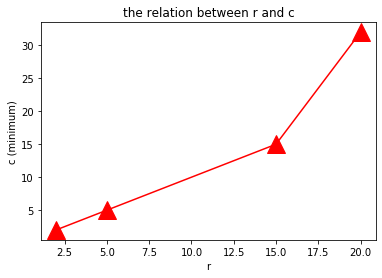

In [22]:
plt.plot(r_repo,c_repo,marker='^',color = 'r',markersize=18, label='$\epsilon=0.01$')
plt.xlabel('r')
plt.ylabel('c (minimum)')
plt.title("the relation between r and c")

#### According to the figure above, c is related to the r which is consistent with the courses